In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [155]:
gestures = [
    0,
    1,
    2,
    3,
    4,
    5,
    6,
    7,
    8,
    9
]
num_samples = 75
num_gestures = len(gestures)

one_hot = np.eye(len(gestures))



fulldata = pd.DataFrame(columns = ['aX','aY','aZ','gX','gY','gZ'])
fullwavedata = pd.DataFrame(columns = ['aX_A1','aX_D1','aY_A1','aY_D1','aZ_A1','aZ_D1','gX_A1','gX_D1','gY_A1','gY_D1','gZ_A1','gZ_D1',
                                       'aX_A2','aX_D2','aY_A2','aY_D2','aZ_A2','aZ_D2','gX_A2','gX_D2','gY_A2','gY_D2','gZ_A2','gZ_D2'])
formatdata = pd.DataFrame()
formatwavedata = pd.DataFrame()

labels = []

for idx, gesture in enumerate(gestures):
    for i in range(1, num_samples+1):
        filepath = 'Training data/test_{0}_{1}.csv'.format(gesture, i)
        data = pd.read_csv(filepath, index_col=False)
        wavedata = pd.DataFrame()
        
        level1 = 5
        wavetype1 = 'dmey'
        
        wavedata['aX_A1'], wavedata['aX_D1'] = wavelet(data['aX'], level=level1, wavelet=wavetype1)
        wavedata['aY_A1'], wavedata['aY_D1'] = wavelet(data['aY'], level=level1, wavelet=wavetype1)
        wavedata['aZ_A1'], wavedata['aZ_D1'] = wavelet(data['aZ'], level=level1, wavelet=wavetype1)

        wavedata['gX_A1'], wavedata['gX_D1'] = wavelet(data['gX'], level=level1, wavelet=wavetype1)
        wavedata['gY_A1'], wavedata['gY_D1'] = wavelet(data['gY'], level=level1, wavelet=wavetype1)
        wavedata['gZ_A1'], wavedata['gZ_D1'] = wavelet(data['gZ'], level=level1, wavelet=wavetype1)
        
        level2 = 2
        wavetype2 = 'rbio2.2'

        wavedata['aX_A2'], wavedata['aX_D2'] = wavelet(data['aX'], level=level2, wavelet=wavetype2)
        wavedata['aY_A2'], wavedata['aY_D2'] = wavelet(data['aY'], level=level2, wavelet=wavetype2)
        wavedata['aZ_A2'], wavedata['aZ_D2'] = wavelet(data['aZ'], level=level2, wavelet=wavetype2)

        wavedata['gX_A2'], wavedata['gX_D2'] = wavelet(data['gX'], level=level2, wavelet=wavetype2)
        wavedata['gY_A2'], wavedata['gY_D2'] = wavelet(data['gY'], level=level2, wavelet=wavetype2)
        wavedata['gZ_A2'], wavedata['gZ_D2'] = wavelet(data['gZ'], level=level2, wavelet=wavetype2)
        
        wavelen = len(wavedata)
        
        fullwavedata = fullwavedata.append(wavedata)
        fulldata = fulldata.append(data)
        label = gesture
        labels.append(label)
        del data, wavedata

labels = np.array(labels)


In [65]:
normaldata = (fulldata - fulldata.min()) / (fulldata.max()-fulldata.min())
normaldata.describe()

,aX,aY,aZ,gX,gY,gZ
count,187500.000000,187500.000000,187500.000000,187500.000000,187500.000000,187500.000000
mean,0.556201,0.396600,0.411886,0.454160,0.500663,0.462613
std,0.078789,0.086354,0.088734,0.097145,0.082059,0.084265
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.511782,0.334402,0.385616,0.433912,0.484199,0.446379
50%,0.556940,0.399080,0.418664,0.451369,0.499626,0.460416
75%,0.596337,0.448060,0.438756,0.469123,0.511177,0.475276
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [78]:
formatdata = pd.DataFrame()

for idx, gesture in enumerate(gestures):
    for i in range(1, 76):#num_samples+1):
        
        index = idx*num_samples*250 + (i-1) * 250
        #print(index, index+250)
        dataf = normaldata.iloc[index:index+250].to_numpy().flatten().tolist()
        formatdata[idx*num_samples+i-1] = dataf
        del dataf
        
        
formatdata = formatdata.transpose().to_numpy()
formatdata


array([[0.59109008, 0.2476167 , 0.68156393, ..., 0.46262777, 0.49748989,
        0.45681224],
       [0.64908418, 0.24276792, 0.60291096, ..., 0.47850967, 0.49866484,
        0.44382851],
       [0.68328102, 0.42784352, 0.43105023, ..., 0.44081607, 0.48673228,
        0.46163898],
       ...,
       [0.49482363, 0.50887574, 0.6678653 , ..., 0.46318758, 0.56757458,
        0.41687042],
       [0.63240736, 0.35650888, 0.49315068, ..., 0.46642201, 0.50051118,
        0.42793609],
       [0.6203682 , 0.31969099, 0.4734589 , ..., 0.44228815, 0.50371557,
        0.46279825]])

In [136]:
import pywt
def wavelet(data, level, wavelet):
    (cA, cD) = pywt.dwt(data, wavelet=wavelet)
    for i in range(1, level):
        (cA, cD) = pywt.dwt(cA, wavelet=wavelet)
    return cA, cD



In [156]:
normalwavedata = (fullwavedata - fullwavedata.min()) / (fullwavedata.max()-fullwavedata.min())
normalwavedata.describe()

,aX_A1,aX_D1,aY_A1,aY_D1,aZ_A1,aZ_D1,gX_A1,gX_D1,gY_A1,gY_D1,...,aY_A2,aY_D2,aZ_A2,aZ_D2,gX_A2,gX_D2,gY_A2,gY_D2,gZ_A2,gZ_D2
count,49500.000000,49500.000000,49500.000000,49500.000000,49500.000000,49500.000000,49500.000000,49500.000000,49500.000000,49500.000000,...,49500.000000,49500.000000,49500.000000,49500.000000,49500.000000,49500.000000,49500.000000,49500.000000,49500.000000,49500.000000
mean,0.497516,0.467960,0.412851,0.517696,0.513952,0.523925,0.478586,0.520926,0.511014,0.537456,...,0.398164,0.381732,0.453108,0.721203,0.429104,0.492332,0.501349,0.482749,0.457911,0.566090
std,0.097294,0.060203,0.109414,0.083133,0.104303,0.090857,0.115142,0.074926,0.069332,0.062208,...,0.096932,0.028289,0.102511,0.026659,0.107746,0.035894,0.080755,0.029401,0.087218,0.032067
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.437812,0.458941,0.329817,0.506758,0.476832,0.515462,0.441037,0.514579,0.488013,0.527616,...,0.327640,0.377211,0.421493,0.717386,0.406099,0.489741,0.484787,0.479179,0.441368,0.562537
50%,0.498379,0.467819,0.416661,0.517474,0.521585,0.525455,0.499227,0.521080,0.494951,0.537779,...,0.401008,0.381723,0.459248,0.721250,0.425846,0.492822,0.499732,0.482529,0.456847,0.566152
75%,0.553838,0.475911,0.484513,0.532906,0.548347,0.538299,0.514813,0.534569,0.520263,0.545159,...,0.456683,0.386304,0.482633,0.725293,0.445805,0.496821,0.511463,0.485648,0.471580,0.569730
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [157]:
formatwavedata = pd.DataFrame()
print(wavelen)
for idx, gesture in enumerate(gestures):
    for i in range(1, 76):#num_samples+1):
        
        index = idx*num_samples*wavelen + (i-1) * wavelen
        #print(index, index+250)
        wavedataf = normalwavedata.iloc[index:index+wavelen].to_numpy().flatten().tolist()
        formatwavedata[idx*num_samples+i-1] = wavedataf
        del wavedataf
        
        
formatwavedata = formatwavedata.transpose().to_numpy()
formatwavedata 


66


array([[0.63299382, 0.47970438, 0.14634482, ..., 0.48133294, 0.45298797,
        0.56554193],
       [0.68543138, 0.42927659, 0.23015975, ..., 0.48546033, 0.43824259,
        0.56975438],
       [0.49537685, 0.44529983, 0.43293935, ..., 0.48927799, 0.45733925,
        0.55820254],
       ...,
       [0.48369692, 0.55754372, 0.39617257, ..., 0.48567272, 0.41288343,
        0.56390029],
       [0.63542805, 0.4983797 , 0.32888552, ..., 0.48247806, 0.42154822,
        0.56637728],
       [0.65150173, 0.45430185, 0.32573367, ..., 0.48076658, 0.46050967,
        0.56339774]])

In [158]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(formatdata2, labels, test_size=0.15)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15/0.85)


In [159]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model = None
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(512, activation='relu')) # relu is used for performance
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(len(gestures), activation='softmax'))
model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [160]:
from tensorflow import keras
from tensorflow.keras import layers, callbacks

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001, # minimium amount of change to count as an improvement
    patience=25, # how many epochs to wait before stopping
    restore_best_weights=True,

)
history = model.fit(X_train, y_train, 
                    epochs=600,
                    batch_size=16,
                    callbacks=[early_stopping],
                    validation_data=(X_val, y_val))



Epoch 1/600
33/33 [==============================] - 1s 24ms/step - loss: 2.2893 - sparse_categorical_accuracy: 0.1298 - val_loss: 2.2317 - val_sparse_categorical_accuracy: 0.2566
Epoch 2/600
33/33 [==============================] - 1s 15ms/step - loss: 2.1725 - sparse_categorical_accuracy: 0.2595 - val_loss: 2.0745 - val_sparse_categorical_accuracy: 0.3540
Epoch 3/600
33/33 [==============================] - 0s 14ms/step - loss: 2.0385 - sparse_categorical_accuracy: 0.3969 - val_loss: 1.9041 - val_sparse_categorical_accuracy: 0.4690
Epoch 4/600
33/33 [==============================] - 1s 19ms/step - loss: 1.8795 - sparse_categorical_accuracy: 0.4427 - val_loss: 1.8215 - val_sparse_categorical_accuracy: 0.4071
Epoch 5/600
33/33 [==============================] - 0s 14ms/step - loss: 1.7072 - sparse_categorical_accuracy: 0.4695 - val_loss: 1.5306 - val_sparse_categorical_accuracy: 0.5929
Epoch 6/600
33/33 [==============================] - 0s 14ms/step - loss: 1.5631 - sparse_categorica

33/33 [==============================] - 0s 14ms/step - loss: 0.3398 - sparse_categorical_accuracy: 0.9046 - val_loss: 0.4326 - val_sparse_categorical_accuracy: 0.8496
Epoch 47/600
33/33 [==============================] - 0s 13ms/step - loss: 0.2975 - sparse_categorical_accuracy: 0.9103 - val_loss: 0.4955 - val_sparse_categorical_accuracy: 0.8673
Epoch 48/600
33/33 [==============================] - 0s 13ms/step - loss: 0.2910 - sparse_categorical_accuracy: 0.9141 - val_loss: 0.5017 - val_sparse_categorical_accuracy: 0.8407
Epoch 49/600
33/33 [==============================] - 0s 13ms/step - loss: 0.2677 - sparse_categorical_accuracy: 0.9237 - val_loss: 0.4639 - val_sparse_categorical_accuracy: 0.8230
Epoch 50/600
33/33 [==============================] - 0s 13ms/step - loss: 0.3197 - sparse_categorical_accuracy: 0.8989 - val_loss: 0.4958 - val_sparse_categorical_accuracy: 0.8584
Epoch 51/600
33/33 [==============================] - 0s 15ms/step - loss: 0.2747 - sparse_categorical_accur

33/33 [==============================] - 0s 13ms/step - loss: 0.1158 - sparse_categorical_accuracy: 0.9752 - val_loss: 0.4070 - val_sparse_categorical_accuracy: 0.8850
Epoch 92/600
33/33 [==============================] - 0s 12ms/step - loss: 0.1011 - sparse_categorical_accuracy: 0.9771 - val_loss: 0.4076 - val_sparse_categorical_accuracy: 0.8761
Epoch 93/600
33/33 [==============================] - 0s 13ms/step - loss: 0.1105 - sparse_categorical_accuracy: 0.9695 - val_loss: 0.5359 - val_sparse_categorical_accuracy: 0.8407
Epoch 94/600
33/33 [==============================] - 0s 13ms/step - loss: 0.1054 - sparse_categorical_accuracy: 0.9714 - val_loss: 0.3573 - val_sparse_categorical_accuracy: 0.9115
Epoch 95/600
33/33 [==============================] - 0s 12ms/step - loss: 0.1035 - sparse_categorical_accuracy: 0.9752 - val_loss: 0.4036 - val_sparse_categorical_accuracy: 0.8673
Epoch 96/600
33/33 [==============================] - 0s 13ms/step - loss: 0.0987 - sparse_categorical_accur

4/4 [==============================] - 0s 4ms/step - loss: 0.6273 - sparse_categorical_accuracy: 0.9027


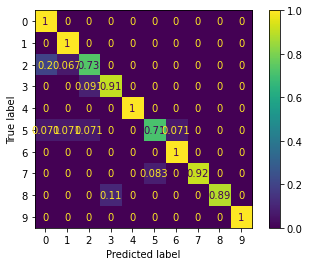

In [162]:
model.evaluate(X_test, y_test)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

prediction = np.round(model.predict(X_test), decimals=3)
prediction

prediction_lbl = np.argmax(prediction, axis=1)
test_lbl = y_test

cm = confusion_matrix(test_lbl, prediction_lbl, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## Try out different network sizes

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers, callbacks

hyperparameters = pd.DataFrame()

validation = []
for i in range(1,11):

    model = None
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(2048, activation='relu')) # relu is used for performance
    model.add(tf.keras.layers.Dense(1024, activation='relu'))
    model.add(tf.keras.layers.Dense(512, activation='relu'))
    model.add(tf.keras.layers.Dense(len(gestures), activation='softmax'))
    model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=[tf.keras.metrics.CategoricalAccuracy()])

    early_stopping = callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0.0001, # minimium amount of change to count as an improvement
        patience=25, # how many epochs to wait before stopping
        restore_best_weights=True,
    )

    X_train, X_test, y_train, y_test = train_test_split(formatdata, labels, test_size=0.15)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15/0.85)

    history = model.fit(X_train, y_train, 
                        epochs=600,
                        batch_size=64,
                        callbacks=[early_stopping],
                        validation_data=(X_val, y_val),
                        verbose=0)
    
    validation.append(model.evaluate(X_test, y_test))

np.average(validation, axis=0)


## Hyperparameter Optimization

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers, callbacks

hyperparameters = pd.DataFrame()
for s in range(6,12):
    for n in range(4, 10):
        validation = []
        for i in range(1,11):       
            
            model = None
            opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
            model = tf.keras.Sequential()
            model.add(tf.keras.layers.Dense(2**s, activation='relu')) # relu is used for performance
            model.add(tf.keras.layers.Dense(2**s, activation='relu'))
            model.add(tf.keras.layers.Dense(2**s, activation='relu'))
            model.add(tf.keras.layers.Dense(len(gestures), activation='softmax'))
            model.compile(optimizer=opt, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=[tf.keras.metrics.CategoricalAccuracy()])

            early_stopping = callbacks.EarlyStopping(
                monitor='val_loss',
                min_delta=0.0001, # minimium amount of change to count as an improvement
                patience=25, # how many epochs to wait before stopping
                restore_best_weights=True,
            )

            X_train, X_test, y_train, y_test = train_test_split(formatdata, labels, test_size=0.15)
            X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15/0.85)

            model.fit(X_train, y_train, 
                                epochs=600,
                                batch_size=2**n,
                                callbacks=[early_stopping],
                                validation_data=(X_val, y_val),
                                verbose=0)
            
            validation.append(model.evaluate(X_test, y_test, verbose=0))
            
        indexing = 'size={0},bs={1}'.format(2**s,2**n)
        hyperparameters[indexing] = np.average(validation, axis=0)
        print(indexing)
        hyperparameters.transpose().to_csv('Training data/Search results.csv') 

  
hyperparameters

In [ ]:
hyperparameters

## Train model on full data

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers, callbacks

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(512, activation='relu')) # relu is used for performance
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(len(gestures), activation='softmax'))
model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=[tf.keras.metrics.CategoricalAccuracy()])

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001, # minimium amount of change to count as an improvement
    patience=25, # how many epochs to wait before stopping
    restore_best_weights=True,
)

X_train, X_val, y_train, y_val = train_test_split(formatdata, labels, test_size=0.2)

history = model.fit(X_train, y_train, 
                    epochs=600,
                    batch_size=32,
                    callbacks=[early_stopping],
                    validation_data=(X_val, y_val),
                    verbose=1)


In [138]:
data = pd.read_csv('Training data/test_0_1.csv', index_col=False)


for wavelets in pywt.wavelist(kind='discrete'):
    cA, cD = wavelet(data['aX'], level=4, wavelet=wavelets)
    print(wavelets, len(cA))

bior1.1 16
bior1.3 20
bior1.5 24
bior2.2 20
bior2.4 24
bior2.6 27
bior2.8 31
bior3.1 18
bior3.3 22
bior3.5 25
bior3.7 29
bior3.9 33
bior4.4 24
bior5.5 25
bior6.8 31
coif1 20
coif2 25
coif3 31
coif4 37
coif5 42
coif6 48
coif7 54
coif8 59
coif9 65
coif10 70
coif11 76
coif12 82
coif13 87
coif14 93
coif15 99
coif16 104
coif17 110
db1 16
db2 18
db3 20
db4 22
db5 24
db6 25
db7 27
db8 29
db9 31
db10 33
db11 35
db12 37
db13 39
db14 40
db15 42
db16 44
db17 46
db18 48
db19 50
db20 52
db21 54
db22 55
db23 57
db24 59
db25 61
db26 63
db27 65
db28 67
db29 69
db30 70
db31 72
db32 74
db33 76
db34 78
db35 80
db36 82
db37 84
db38 85
dmey 72
haar 16
rbio1.1 16
rbio1.3 20
rbio1.5 24
rbio2.2 20
rbio2.4 24
rbio2.6 27
rbio2.8 31
rbio3.1 18
rbio3.3 22
rbio3.5 25
rbio3.7 29
rbio3.9 33
rbio4.4 24
rbio5.5 25
rbio6.8 31
sym2 18
sym3 20
sym4 22
sym5 24
sym6 25
sym7 27
sym8 29
sym9 31
sym10 33
sym11 35
sym12 37
sym13 39
sym14 40
sym15 42
sym16 44
sym17 46
sym18 48
sym19 50
sym20 52


In [149]:
data = pd.read_csv('Training data/test_0_1.csv', index_col=False)


for wavelets in pywt.wavelist(kind='discrete'):
    cA, cD = wavelet(data['aX'], level=2, wavelet=wavelets)
    print(wavelets, len(cA))
    

bior1.1 250
bior1.3 250
bior1.5 250
bior2.2 250
bior2.4 250
bior2.6 250
bior2.8 250
bior3.1 250
bior3.3 250
bior3.5 250
bior3.7 250
bior3.9 250
bior4.4 250
bior5.5 250
bior6.8 250
coif1 250
coif2 250
coif3 250
coif4 250
coif5 250
coif6 250
coif7 250
coif8 250
coif9 250
coif10 250
coif11 250
coif12 250
coif13 250
coif14 250
coif15 250
coif16 250
coif17 250
db1 250
db2 250
db3 250
db4 250
db5 250
db6 250
db7 250
db8 250
db9 250
db10 250
db11 250
db12 250
db13 250
db14 250
db15 250
db16 250
db17 250
db18 250
db19 250
db20 250
db21 250
db22 250
db23 250
db24 250
db25 250
db26 250
db27 250
db28 250
db29 250
db30 250
db31 250
db32 250
db33 250
db34 250
db35 250
db36 250
db37 250
db38 250
dmey 250
haar 250
rbio1.1 250
rbio1.3 250
rbio1.5 250
rbio2.2 250
rbio2.4 250
rbio2.6 250
rbio2.8 250
rbio3.1 250
rbio3.3 250
rbio3.5 250
rbio3.7 250
rbio3.9 250
rbio4.4 250
rbio5.5 250
rbio6.8 250
sym2 250
sym3 250
sym4 250
sym5 250
sym6 250
sym7 250
sym8 250
sym9 250
sym10 250
sym11 250
sym12 250
sym13 250

array([[2.11907043, 6.82421168, 5.54193904, ..., 5.47097165, 2.03045972,
        6.6133078 ],
       [1.76582527, 7.07106004, 5.58133428, ..., 5.51645218, 1.65935855,
        6.89269203],
       [1.28792127, 7.44748464, 5.65716753, ..., 5.60261207, 1.15739409,
        7.31969186],
       ...,
       [1.77345531, 1.59840199, 1.74877987, ..., 1.71594344, 1.81150374,
        1.44454511],
       [1.79842513, 1.46981649, 1.67034383, ..., 1.63695682, 1.84105714,
        1.31106903],
       [1.83006621, 1.42822707, 1.65457439, ..., 1.62030465, 1.87439826,
        1.26555314]])